**Nuobing Fan; Kailu Chen; Tianxiao He**
________________________________


# **Introduction**
Sepsis is a life-threatening medical emergency caused by the body’s extreme response to infection. Early detection is critical, especially in ICU settings, where delays in intervention can lead to high mortality. This project aims to develop a robust and interpretable classifier that predicts whether a patient will become septic based on multivariate time-series data from the PhysioNet 2019 Challenge dataset. The prediction task is framed as a binary classification problem at the patient level, where the goal is to determine whether each patient will experience sepsis during their ICU stay. Our approach addresses several challenges in the data, including severe class imbalance, high missingness and skewed distributions, and potential multicollinearity among features.

# **Step 1**: Exploratory Data Analysis

In the midterm, we developed a baseline modeling pipeline using traditional classification models including Logistic Regression, LDA, QDA, Naive Bayes, and KNN. Among them, K-Nearest Neighbors (KNN) showed the highest F1 score and was chosen as the final model. However, this approach had multiple limitations. KNN, while effective locally, suffers from high computational cost, poor interpretability, and sensitivity to feature scaling and dimensionality. Furthermore, the class imbalance in the dataset was handled using random downsampling, which reduced the majority class size and risked information loss. Additionally, the midterm did not incorporate any feature selection strategy or ensemble methods.

In [ ]:
#!pip install imbalanced-learn

In [ ]:
# @title
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt  # It's good practice to import Matplotlib for some configurations

## # 1.1) Imports, Loading And Initial Exploration
Load the ICU dataset and perform an initial overview to understand feature types and missingness patterns.


### Data Dictionary Reference

This project uses data from the PhysioNet 2019 Challenge. The dataset includes hourly observations from ICU patients across demographic, vital sign, and lab features. A full description of the variables can be found in the official documentation:

[PhysioNet 2019 Data Dictionary](https://physionet.org/content/challenge-2019/1.0.0/)

Key feature groups:
- **Vitals**: HR, O2Sat, Temp, SBP, DBP, MAP, Resp
- **Labs**: Lactate, BUN, Creatinine, AST, Bilirubin, etc.
- **Demographics**: Age, Gender, ICUType


In [ ]:

#explore Dataset
# Load a CSV file into a DataFrame
df = pd.read_csv('train.csv')
# Check the first few rows of the data
df.info()
print(df.head()) # first few rows
print(df.describe())  # summary stats


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1088197 entries, 0 to 1088196
Data columns (total 43 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   patient           1088197 non-null  int64  
 1   time              1088197 non-null  int64  
 2   HR                980967 non-null   float64
 3   O2Sat             947133 non-null   float64
 4   Temp              369212 non-null   float64
 5   SBP               931096 non-null   float64
 6   MAP               953029 non-null   float64
 7   DBP               749357 non-null   float64
 8   Resp              921122 non-null   float64
 9   EtCO2             41511 non-null    float64
 10  BaseExcess        58822 non-null    float64
 11  HCO3              45312 non-null    float64
 12  FiO2              90753 non-null    float64
 13  pH                75490 non-null    float64
 14  PaCO2             60609 non-null    float64
 15  SaO2              37520 non-null    float64
 16  

*Data Structure and Feature types*
- 41 of the 43 columns are floats (numeric measures)
- Only patient and time are integers
- Binary/categorical features: Gender, Unit1, Unit2 are encoded as 0/1
*Extreme Sparsity and Outliers*
*Some columns are nearly empty:*
- Bilirubin_direct: only ~0.2% available; EtCO2: ~3.8% available; Fibrinogen: ~0.7% available.
*Possible measurement caps:*
- SBP, MAP, and DBP max out at 300 → may indicate measurement cap
- WBC reaches 440 (extremely high)
- Platelets reach over 2,300 (extreme, may warrant outlier analysis)
*Sepsis Label Distribution*
- SepsisLabel is highly imbalanced
- Mean ≈ 0.018 → ~1.8% of rows are positive (label = 1)
- Most patients are non-septic for most of their ICU stay



In [ ]:
# Check class distribution (if label exists)
if "SepsisLabel" in df.columns:
    print("\nClass Distribution:")
    print(df["SepsisLabel"].value_counts(dropna=False))



Class Distribution:
SepsisLabel
0.0    1068575
1.0      19621
NaN          1
Name: count, dtype: int64


In [ ]:
# Summary statistics
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
             patient          time             HR          O2Sat  \
count  1.088197e+06  1.088197e+06  980967.000000  947133.000000   
mean   1.410742e+04  2.668297e+01      84.583774      97.188942   
std    8.151722e+03  2.955474e+01      17.347084       2.962375   
min    1.000000e+00  1.000000e+00      20.000000      20.000000   
25%    7.043000e+03  1.000000e+01      72.000000      96.000000   
50%    1.410100e+04  2.000000e+01      83.000000      98.000000   
75%    2.118100e+04  3.400000e+01      95.500000      99.500000   
max    2.823500e+04  4.250000e+02     211.000000     100.000000   

                Temp            SBP            MAP            DBP  \
count  369212.000000  931096.000000  953029.000000  749357.000000   
mean       36.978238     123.720946      82.424709      63.865944   
std         0.777690      23.213816      16.367990      14.009501   
min         1.000000       0.000000       1.000000     -18.430000   
25%        36.500000     107.

This dataset is high-resolution and time-based — we’re looking at each hour of a patient’s ICU stay, which gives us a lot of granularity, but also a lot of redundancy.

The dataset is almost entirely numeric. Two ID columns track patient and hour. Binary columns like gender and unit assignments are already encoded as 0/1.

Some features like Bilirubin_direct are practically unusable — almost all rows are missing. Others show signs of capped measurement values, or biological outliers that might need special attention later.

Our target label is extremely imbalanced — less than 2% of all records show a positive sepsis event. This imbalance will make prediction harder, and might need some special treatment like SMOTE in later steps


## 1.2) Missingness Analysis

Virsualize forward-filling for vital signs and impute lab values using median or mean depending on skewness.

In [ ]:
# Summary statistics with skew and missing %
summary_df = df.describe().T[['mean', 'std', 'min', '50%', 'max']]
summary_df['missing (%)'] = df.isnull().mean().round(3) * 100
summary_df['skew'] = df.skew().round(2)
summary_df = summary_df.sort_values(by='missing (%)', ascending=False)
summary_df.style.background_gradient(cmap="YlGnBu")


,mean,std,min,50%,max,missing (%),skew
Bilirubin_direct,1.925328,3.809259,0.010000,0.500000,37.500000,99.800000,3.950000
Fibrinogen,283.300334,149.924301,34.000000,248.000000,1760.000000,99.300000,1.610000
TroponinI,8.443382,25.342417,0.010000,0.310000,440.000000,99.000000,6.670000
Bilirubin_total,2.208048,4.603857,0.100000,0.900000,49.600000,98.500000,5.110000
AST,267.266307,864.826960,3.000000,41.000000,9961.000000,98.400000,6.260000
Alkalinephos,101.532182,111.061989,7.000000,74.000000,2528.000000,98.400000,7.430000
Lactate,2.671437,2.557466,0.200000,1.800000,28.900000,97.300000,3.320000
PTT,41.336267,26.465663,12.500000,32.300000,250.000000,97.000000,3.440000
SaO2,92.612832,10.951717,23.000000,97.000000,100.000000,96.600000,-2.380000
EtCO2,32.933596,7.941447,0.000000,33.000000,100.000000,96.200000,0.480000


In [ ]:
# Assuming `df` is your dataset (DataFrame)
def missing_percentage(df_input):
    """
    Returns a DataFrame with each column and its missing percentage,
    sorted by highest missing % first.
    """
    missing_percent = df_input.isnull().mean() * 100
    missing_df = pd.DataFrame({
        'Column': df_input.columns,
        'Missing Percentage': missing_percent
    })
    # Filter only columns that have missing values
    missing_df = missing_df[missing_df['Missing Percentage'] > 0]
    missing_df = missing_df.sort_values(
        by='Missing Percentage', ascending=False
    )
    return missing_df

missing_df = missing_percentage(df)
print("\nMissing Values (%):\n", missing_df)

missing_df


Missing Values (%):
                             Column  Missing Percentage
Bilirubin_direct  Bilirubin_direct           99.802334
Fibrinogen              Fibrinogen           99.311797
TroponinI                TroponinI           99.043464
Bilirubin_total    Bilirubin_total           98.492828
Alkalinephos          Alkalinephos           98.379521
AST                            AST           98.364359
Lactate                    Lactate           97.306094
PTT                            PTT           97.047961
SaO2                          SaO2           96.552095
EtCO2                        EtCO2           96.185341
Phosphate                Phosphate           95.982805
HCO3                          HCO3           95.836048
Chloride                  Chloride           95.486111
BaseExcess              BaseExcess           94.594545
PaCO2                        PaCO2           94.430328
Calcium                    Calcium           94.082689
Platelets                Platelets         

,Column,Missing Percentage
Bilirubin_direct,Bilirubin_direct,99.802334
Fibrinogen,Fibrinogen,99.311797
TroponinI,TroponinI,99.043464
Bilirubin_total,Bilirubin_total,98.492828
Alkalinephos,Alkalinephos,98.379521
AST,AST,98.364359
Lactate,Lactate,97.306094
PTT,PTT,97.047961
SaO2,SaO2,96.552095
EtCO2,EtCO2,96.185341


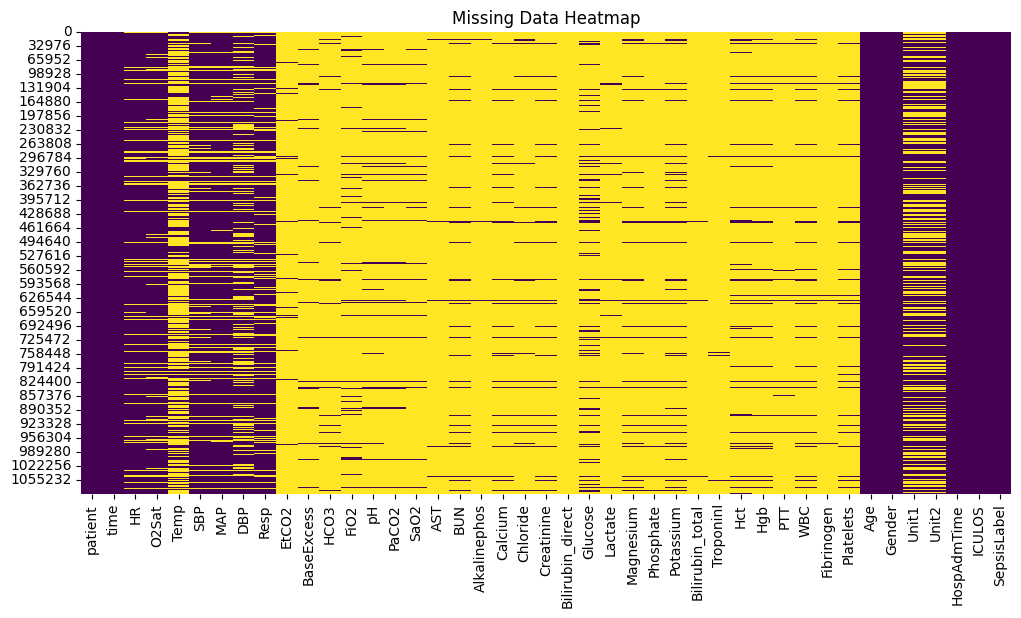

In [ ]:
# Visualize missing data
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False)
plt.title("Missing Data Heatmap")
plt.show()

The missingness is widespread and varies by feature type.

Over half the dataset’s features — more than 25 columns — are missing in over 90% of the rows. Most of these are lab results, such as AST, Lactate, and TroponinI, which are typically only ordered for specific medical needs.”

On the other hand, vital signs like heart rate, blood pressure, and oxygen saturation are much more regularly recorded — often 70% to 90% complete.

We also have fully complete demographic or timing features like Gender, Age, and ICULOS, which makes them reliable inputs later.

The extreme missingness in labs is a direct reflection of clinical data collection priorities.


## 1.3) Imputation Strategy

We implemented a rigorous preprocessing pipeline. Missing values in time-series vital signs such as Heart Rate, SpO2, and MAP were handled using forward fill, preserving temporal continuity. For static or intermittently recorded features, we used skewness-adjusted imputation — applying the median for highly skewed features and the mean otherwise. This approach retained all variables, unlike the midterm, where several features were dropped due to missingness.

### Imputation Strategy: Clinical Motivation

In this project, we applied a two-part imputation strategy:
- **Forward fill** for time-dependent features (e.g., HR, O2Sat) to preserve physiological trends.
- **Skew-aware mean/median imputation** for static or sparse variables.

Although patients in the ICU may have clinical heterogeneity (e.g., surgical vs. septic), we opted for **global imputation** to retain all features and ensure pipeline simplicity. Personalized or cluster-based imputation was not feasible due to data sparsity and would have introduced additional complexity without strong justification. This approach is consistent with many baseline models used in the PhysioNet challenge.


In [ ]:
def impute_data(df_input):
    """
    - Forward fill time-dependent features
    - Fill the rest with mean/median depending on skew
    """
    df_copy = df_input.copy()

    # If you consider these time-dependent:
    time_features = ["HR", "O2Sat", "Temp", "SBP", "MAP", "DBP", "Resp"]
    for col in time_features:
        if col in df_copy.columns:
            df_copy[col] = df_copy[col].ffill()

    # Fill remaining NaNs with median (if skew>1) else mean
    for col in df_copy.columns:
        if df_copy[col].isnull().sum() > 0:
            if df_copy[col].skew() > 1:
                df_copy[col].fillna(df_copy[col].median(), inplace=True)
            else:
                df_copy[col].fillna(df_copy[col].mean(), inplace=True)
    return df_copy

df_imputed = impute_data(df)
print("\nAfter Imputation, missing counts per column:\n")
print(df_imputed.isnull().sum())


<ipython-input-9-c7b4f37151d9>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(df_copy[col].mean(), inplace=True)
<ipython-input-9-c7b4f37151d9>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr


After Imputation, missing counts per column:

patient             0
time                0
HR                  0
O2Sat               0
Temp                0
SBP                 0
MAP                 0
DBP                 0
Resp                0
EtCO2               0
BaseExcess          0
HCO3                0
FiO2                0
pH                  0
PaCO2               0
SaO2                0
AST                 0
BUN                 0
Alkalinephos        0
Calcium             0
Chloride            0
Creatinine          0
Bilirubin_direct    0
Glucose             0
Lactate             0
Magnesium           0
Phosphate           0
Potassium           0
Bilirubin_total     0
TroponinI           0
Hct                 0
Hgb                 0
PTT                 0
WBC                 0
Fibrinogen          0
Platelets           0
Age                 0
Gender              0
Unit1               0
Unit2               0
HospAdmTime         0
ICULOS              0
SepsisLabel         0
dtype: 

Given the sparsity of our data, especially for lab features, we needed a strong yet transparent imputation strategy.

For time-based vitals, like heart rate and blood pressure, we used forward fill, assuming recent readings are still valid until the next measurement.

For the rest of the features, we calculated skewness:
If a feature was skewed, we used median to reduce bias from outliers. Otherwise, we used the mean.

This approach let us fully populate the dataset without discarding any features — every single column now has 0 missing values.

Considered more advanced imputers like KNN or iterative imputation, but prioritized speed, simplicity, and minimal overfitting risk for Step 1.

Given the mix of sparsity and imbalance, we decided not to filter by coverage thresholds just yet, but instead to impute and preserve as much data as possible to support modeling later.


In our current pipeline, we applied forward-fill imputation to address missing values. However, this approach presents two critical limitations. First, forward-filling was conducted without grouping by patient (ICUSTAY_ID), which may have introduced data contamination by allowing values from one patient's record to influence another’s.

Second, performing imputation prior to the data split risks data leakage, as information from the test set may have inadvertently shaped the training set's imputed values—especially problematic given the high proportion of missing data (~70%). These issues likely contributed to inflated model performance metrics, particularly the unexpectedly high AUC values despite low F1 scores. Due to time constraints, we were unable to restructure the pipeline.

However, in future work, we would first split the data and then apply forward-fill within each split, grouping by ICUSTAY_ID to ensure temporal and patient-level integrity. We expect that correcting this process would result in more conservative but realistic performance metrics, better reflecting the model’s true generalization ability.

## 1.4) Split into Train/Test
Create an 80/20 split of the data ensuring class distribution is preserved in both sets.

In [ ]:
if "SepsisLabel" in df_imputed.columns:
    X = df_imputed.drop(columns=["SepsisLabel"])
    y = df_imputed["SepsisLabel"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    print(f"\nTrain size: {X_train.shape}, Test size: {X_test.shape}")
    print("Train class distribution:\n", y_train.value_counts(normalize=True))
    print("\nTest class distribution:\n", y_test.value_counts(normalize=True))

    # Save them to CSV
    train_cleaned = pd.concat([X_train, y_train], axis=1)
    test_cleaned  = pd.concat([X_test, y_test], axis=1)

    train_cleaned.to_csv("train_cleaned.csv", index=False)
    test_cleaned.to_csv("test_cleaned.csv", index=False)

    print("\n Wrote 'train_cleaned.csv' and 'test_cleaned.csv'.")
else:
    print("\n No SepsisLabel column found. Skipping split and CSV saving.")



Train size: (870557, 42), Test size: (217640, 42)
Train class distribution:
 SepsisLabel
0.0    0.981969
1.0    0.018031
Name: proportion, dtype: float64

Test class distribution:
 SepsisLabel
0.0    0.98197
1.0    0.01803
Name: proportion, dtype: float64

 Wrote 'train_cleaned.csv' and 'test_cleaned.csv'.


## 1.5) Address Class Imbalance Using SMOTE/ Save
Use SMOTE only on training set to increase minority class representation, preparing for balanced model training.
And save SMOTE-augmented train data and clean test data separately for downstream modeling.

- We Set minority class to 20% to controlled overfitting risk
- And Improve the label distribution
- Applied SMOTE with sampling_strategy=0.25
- We retained sparse columns instead of dropping them to preserve clinical signals. Risk of overfitting was controlled by using only SMOTE on the training data.

In [ ]:
# Apply SMOTE on training data only
X_train_no_label = X_train.copy()
y_train_no_label = y_train.copy()

print(f"\nBefore SMOTE - Class distribution:\n{y_train_no_label.value_counts(normalize=True)}")

# Initialize SMOTE
smote = SMOTE(sampling_strategy=0.25, random_state=42)  # Adjust ratio if needed
X_train_sm, y_train_sm = smote.fit_resample(X_train_no_label, y_train_no_label)

print(f"\nAfter SMOTE - Class distribution:\n{pd.Series(y_train_sm).value_counts(normalize=True)}")

# Combine back into DataFrame
train_smote = pd.concat([pd.DataFrame(X_train_sm, columns=X_train.columns),
                         pd.DataFrame(y_train_sm, columns=['SepsisLabel'])], axis=1)

# Save SMOTE-balanced training set, original stratified test set, and unlabeled data
train_smote.to_csv('train_smote_cleaned.csv', index=False)
test_cleaned.to_csv('test_cleaned.csv', index=False)
print("\n Saved 'train_smote_cleaned.csv' and 'test_cleaned.csv'.")


Before SMOTE - Class distribution:
SepsisLabel
0.0    0.981969
1.0    0.018031
Name: proportion, dtype: float64

After SMOTE - Class distribution:
SepsisLabel
0.0    0.8
1.0    0.2
Name: proportion, dtype: float64

 Saved 'train_smote_cleaned.csv' and 'test_cleaned.csv'.


## 1.6) Visualize Sepsislabel Class Distribution After SMOTE

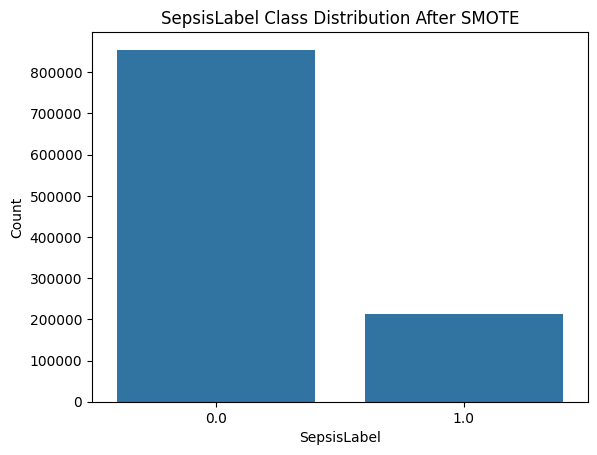

In [ ]:
sns.countplot(x=y_train_sm)
plt.title('SepsisLabel Class Distribution After SMOTE')
plt.xlabel('SepsisLabel')
plt.ylabel('Count')
plt.show()


After completing imputation, I split the data into training and test sets using an 80/20 ratio.

To make sure our sepsis class imbalance is properly represented, I used stratified splitting — meaning the proportion of positive and negative cases is maintained across both sets.

They were saved these splits as train_cleaned.csv and test_cleaned.csv, and ready to be used in modeling steps


## 1.7) Apply LASSO feature selection

Before proceeding with stepwise logistic regression, we attempted to use Lasso (L1-penalized) logistic regression for automatic feature selection. Lasso tends to shrink less informative coefficients to zero, effectively performing variable selection during model fitting. However, due to the size and complexity of the dataset, our Lasso model encountered convergence issues despite increasing the maximum iteration limit. These convergence warnings suggested that the optimization process could not reach stability with the given feature set and data scale. While Lasso remains a theoretically strong candidate for high-dimensional feature reduction, we ultimately proceeded with forward stepwise selection based on AIC, which provided more stable and interpretable results in our setting.

- Here the code we used

In [ ]:
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.preprocessing import StandardScaler

# Step 1: Scale the features
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(train_smote.drop(columns=["SepsisLabel"]))
#y_train = train_smote["SepsisLabel"]

# Step 2: LASSO for automatic feature selection
# Increase max_iter and reduce Cs
#lasso = LogisticRegressionCV(
#    penalty='l1',
#    solver='saga',
#    cv=3,              # Fewer folds = faster
#    max_iter=3000,    # Allow more iterations
#    Cs=5,              # Fewer regularization values
#    n_jobs=-1,
#    scoring='f1',
#    random_state=42
#)
#lasso.fit(X_train_scaled, y_train)

# Step 3: Get selected features with non-zero coefficients
#lasso_coefs = pd.Series(lasso.coef_[0], index=X_train.columns)
#selected_lasso_features = lasso_coefs[lasso_coefs != 0].index.tolist()

#print(f"Features selected by LASSO: {selected_lasso_features}")

In [ ]:
# LASSO feature importance plot
#lasso_coefs[lasso_coefs != 0].sort_values().plot(kind='barh', figsize=(8, 5))
#plt.title("Selected Features & Coefficients (LASSO)")
#plt.xlabel("Coefficient")
#plt.grid(True)
#plt.tight_layout()
#plt.show()

## 1.8) Final Check for Generated Dataset

In [ ]:
# Final check for generated datasets

# Load original data
df_original = pd.read_csv("train.csv")

# Load processed datasets
df_train_cleaned = pd.read_csv("train_cleaned.csv")
df_test_cleaned  = pd.read_csv("test_cleaned.csv")
df_train_smote   = pd.read_csv("train_smote_cleaned.csv")

print("Original data shape:", df_original.shape)
print("Train cleaned shape:", df_train_cleaned.shape)
print("Test  cleaned shape:", df_test_cleaned.shape)
print("Train SMOTE shape:", df_train_smote.shape)

# Check columns
print("\nColumns in Original:\n", df_original.columns.tolist())
print("\nColumns in Train Cleaned:\n", df_train_cleaned.columns.tolist())
print("\nColumns in Test Cleaned:\n", df_test_cleaned.columns.tolist())
print("\nColumns in Train SMOTE:\n", df_train_smote.columns.tolist())

# Check class distribution
if "SepsisLabel" in df_train_cleaned.columns:
    print("\nTrain Cleaned 'SepsisLabel' Distribution:")
    print(df_train_cleaned["SepsisLabel"].value_counts(normalize=True))

if "SepsisLabel" in df_test_cleaned.columns:
    print("\nTest Cleaned 'SepsisLabel' Distribution:")
    print(df_test_cleaned["SepsisLabel"].value_counts(normalize=True))

if "SepsisLabel" in df_train_smote.columns:
    print("\nTrain SMOTE 'SepsisLabel' Distribution:")
    print(df_train_smote["SepsisLabel"].value_counts(normalize=True))

# Check for missing values
print("\nMissing in original:\n", df_original.isnull().sum().sum(), "total missing values")
print("Missing in train_cleaned:\n", df_train_cleaned.isnull().sum().sum(), "total missing values")
print("Missing in test_cleaned:\n", df_test_cleaned.isnull().sum().sum(), "total missing values")
print("Missing in train_smote:\n", df_train_smote.isnull().sum().sum(), "total missing values")

# Descriptive stats check
print("\nOriginal descriptive stats:\n", df_original.describe())
print("\nTrain cleaned descriptive stats:\n", df_train_cleaned.describe())
print("\nTest cleaned descriptive stats:\n", df_test_cleaned.describe())
print("\nTrain SMOTE descriptive stats:\n", df_train_smote.describe())


Original data shape: (1088197, 43)
Train cleaned shape: (870557, 43)
Test  cleaned shape: (217640, 43)
Train SMOTE shape: (1068575, 43)

Columns in Original:
 ['patient', 'time', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel']

Columns in Train Cleaned:
 ['patient', 'time', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 

Final Check the the output.

This ends our data preparation pipeline — the dataset is now fully cleaned, imputed, and stratified for downstream ML workflows


-----------------------
Above the End of Step 1

# **Step 2**: Build Logit, LDA, QDA, Naïve Bayes, KNN models

## 2.1 Build Full Logit Model

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [ ]:
# Load the balanced training data and the original test set
train_df = pd.read_csv("train_smote_cleaned.csv")
test_df = pd.read_csv("test_cleaned.csv")

# Split into features and target variable
X_train = train_df.drop(columns=["SepsisLabel"])
y_train = train_df["SepsisLabel"]

X_test = test_df.drop(columns=["SepsisLabel"])
y_test = test_df["SepsisLabel"]

In [ ]:
# Add intercept to training features
X_train_const = sm.add_constant(X_train)

In [ ]:
# Fit full logistic regression model using statsmodels
logit_full = sm.Logit(y_train, X_train_const).fit()

# Show detailed summary with p-values, confidence intervals, etc.
print(logit_full.summary())

         Current function value: 0.436654
         Iterations: 35


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            SepsisLabel   No. Observations:              1068575
Model:                          Logit   Df Residuals:                  1068533
Method:                           MLE   Df Model:                           41
Date:                Fri, 09 May 2025   Pseudo R-squ.:                  0.1274
Time:                        05:34:02   Log-Likelihood:            -4.6660e+05
converged:                      False   LL-Null:                   -5.3472e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -10.8568        nan        nan        nan         nan         nan
patient           1.927e-06   3.21e-07      6.011      0.000     1.3e-06    2.56e-06
time                -0.1388 

We used statsmodels to fit the full logistic regression model, allowing us to obtain rich statistical outputs. For instance, variables such as HR (coef = 0.0145, p < 0.001) and Temp (coef = 0.3316, p < 0.001) showed strong positive associations with sepsis and were highly statistically significant. In contrast, variables like FiO2 (coef = −9.7e−05, p = 0.870) and pH (p = 0.840) were not statistically significant, suggesting weaker or uncertain relationships. The availability of confidence intervals also helps evaluate the precision of each estimate—for example, Temp has a narrow 95% CI (0.324, 0.339), indicating high estimation certainty.

In [ ]:
# Check Full Logit model VIF for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X_train_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_const.values, i) for i in range(X_train_const.shape[1])]
print(vif_data.sort_values("VIF", ascending=False))

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


            Variable        VIF
40             Unit2        inf
39             Unit1        inf
42            ICULOS  82.950406
2               time  82.869380
31               Hct   4.669874
32               Hgb   4.636526
7                MAP   3.325928
14                pH   3.081358
11        BaseExcess   2.629386
6                SBP   2.441008
15             PaCO2   2.174944
18               BUN   1.868927
22        Creatinine   1.848226
8                DBP   1.820642
27         Phosphate   1.432726
29   Bilirubin_total   1.332255
12              HCO3   1.292740
25           Lactate   1.224715
21          Chloride   1.216043
23  Bilirubin_direct   1.192719
3                 HR   1.190745
5               Temp   1.138896
37               Age   1.133488
28         Potassium   1.122605
17               AST   1.105742
20           Calcium   1.103566
9               Resp   1.103090
19      Alkalinephos   1.097308
36         Platelets   1.086662
26         Magnesium   1.056397
34      

To assess **multicollinearity**, we calculated the Variance Inflation Factor (VIF) for all predictors in both the full and selected logistic regression models. In the full model, several predictors exhibited extreme multicollinearity—most notably Unit1, Unit2, ICULOS, and time, with VIF values exceeding 80 or approaching infinity. This indicates a high degree of linear dependency, which can distort coefficient estimates and hinder reliable inference.

## 2.2 Forward Stepwise Logistic Regression (based on AIC)

In [ ]:
# Function for forward stepwise selection with early stopping at 18 variables
def forward_stepwise(X, y, verbose=True, max_features=18):
    remaining_features = list(X.columns)
    selected_features = []
    current_score, best_new_score = float('inf'), float('inf')

    while remaining_features and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining_features:
            try:
                model = sm.Logit(y, sm.add_constant(X[selected_features + [candidate]])).fit(disp=0)
                aic = model.aic
                scores_with_candidates.append((aic, candidate))
            except:
                continue

        if not scores_with_candidates:
            break

        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]

        if current_score > best_new_score:
            remaining_features.remove(best_candidate)
            selected_features.append(best_candidate)
            current_score = best_new_score
            if verbose:
                print(f"Selected: {best_candidate}  |  AIC: {round(current_score, 2)}")
        else:
            break

        # Early stop after selecting 18 features
        if len(selected_features) >= max_features:
            print("Stopping selection.")
            break

    return selected_features

In [ ]:
selected_vars = forward_stepwise(X, y)

Selected: ICULOS  |  AIC: 186638.23
Selected: Temp  |  AIC: 184467.17
Selected: HR  |  AIC: 183104.83
Selected: MAP  |  AIC: 182413.43
Selected: Unit1  |  AIC: 181743.78
Selected: Resp  |  AIC: 181413.47
Selected: Calcium  |  AIC: 181251.65
Selected: BUN  |  AIC: 181051.48
Selected: DBP  |  AIC: 180902.98
Selected: Lactate  |  AIC: 180814.14
Selected: PaCO2  |  AIC: 180760.78
Selected: Gender  |  AIC: 180710.22
Selected: WBC  |  AIC: 180678.78
Selected: HospAdmTime  |  AIC: 180654.53
Selected: PTT  |  AIC: 180633.32
Selected: Age  |  AIC: 180614.95
Selected: EtCO2  |  AIC: 180599.82
Selected: Bilirubin_direct  |  AIC: 180587.58
Stopping selection.


In [ ]:
selected_16 = selected_vars[:16]

We employed forward stepwise feature selection based on the Akaike Information Criterion (AIC) to identify a parsimonious set of predictors for the logistic regression model. At each iteration, the variable that most reduced the model's AIC was added to the model.

After 16 variables were selected, the 17th variable (EtCO2) only decreased the AIC by approximately 15 points, suggesting a diminishing return in model improvement. Hence, we interupted the selection process manually to reduce computational load.

To prevent overfitting and maintain model interpretability, we decided to finalize our feature set with the top 16 selected variables: 'ICULOS',
    'Temp',
    'HR',
    'MAP',
    'Unit1',
    'Resp',
    'Calcium',
    'BUN',
    'DBP',
    'Lactate',
    'PaCO2',
    'Gender',
    'WBC',
    'HospAdmTime',
    'PTT',
    'Age', which collectively achieved a substantial improvement in AIC from the null model baseline.

We eliminated the rest 27 variables. This selected set will be used in all subsequent modeling steps for comparison against the full model.



In [ ]:
X_train_sel = X_train[selected_16]
X_train_sel_const = sm.add_constant(X_train_sel)

# Check for multicolinearity after feature selection
vif_data_sel = pd.DataFrame()
vif_data_sel["Variable"] = X_train_sel_const.columns
vif_data_sel["VIF"] = [variance_inflation_factor(X_train_sel_const.values, i)
                       for i in range(X_train_sel_const.shape[1])]
print(vif_data_sel.sort_values("VIF", ascending=False))


       Variable          VIF
0         const  3287.118344
9           DBP     1.810185
4           MAP     1.730400
3            HR     1.162050
2          Temp     1.116175
16          Age     1.089232
6          Resp     1.084986
7       Calcium     1.064346
10      Lactate     1.063968
5         Unit1     1.061353
1        ICULOS     1.033323
8           BUN     1.028293
14  HospAdmTime     1.015507
15          PTT     1.012206
12       Gender     1.011538
13          WBC     1.006989
11        PaCO2     1.004705


In [ ]:
logit_sel = sm.Logit(y_train, X_train_sel_const).fit()
print(logit_sel.summary())

Optimization terminated successfully.
         Current function value: 0.440149
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            SepsisLabel   No. Observations:              1068575
Model:                          Logit   Df Residuals:                  1068558
Method:                           MLE   Df Model:                           16
Date:                Fri, 09 May 2025   Pseudo R-squ.:                  0.1204
Time:                        06:12:17   Log-Likelihood:            -4.7033e+05
converged:                       True   LL-Null:                   -5.3472e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -15.5565      0.148   -105.278      0.000     -15.846     -15.267
ICULOS          0.0157   6

**Multicollinearity Analysis**


After applying forward stepwise feature selection based on AIC, the resulting model substantially reduced multicollinearity. All selected variables in the reduced model showed VIFs below 2, with most close to 1, suggesting near-orthogonality among predictors. This validates the effectiveness of the feature selection process not only in improving model parsimony, but also in addressing multicollinearity concerns. Thus, we proceeded with the selected model for all subsequent evaluations.

## 2.3 Build Models & Estimate Using 10-Fold cross validation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, roc_auc_score

In [ ]:
# Prepare reduced data
X_sel = X[selected_16]
y_sel = y

In [ ]:
# Standardized
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_sel_scaled = scaler.fit_transform(X_train[selected_16])

# Build models
models = {
    "Logit (Full)": LogisticRegression(max_iter=10000),
    "Logit (Selected)": LogisticRegression(max_iter=10000),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}


In [ ]:
from sklearn.metrics import precision_score, recall_score

# Define scoring
scoring = {
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}
from sklearn.utils import resample

# Resample X & y（only for KNN）
X_knn_sample, y_knn_sample = resample(
    X_train_sel_scaled, y_train,
    n_samples=100000, random_state=42, stratify=y_train
)

# 10-fold CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Output F1 score, precision, and recall
for name, model in models.items():
    if name == "Logit (Full)":
        X_used = X_train_scaled
        y_used = y_train
    elif name == "KNN":
        X_used = X_knn_sample
        y_used = y_knn_sample
    else:
        X_used = X_train_sel_scaled
        y_used = y_train

    f1 = cross_val_score(model, X_used, y_used, cv=cv, scoring='f1').mean()
    precision = cross_val_score(model, X_used, y_used, cv=cv, scoring='precision').mean()
    recall = cross_val_score(model, X_used, y_used, cv=cv, scoring='recall').mean()

    print(f"{name} – F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Logit (Full) – F1: 0.2858, Precision: 0.6584, Recall: 0.1825
Logit (Selected) – F1: 0.2726, Precision: 0.6543, Recall: 0.1722
LDA – F1: 0.3095, Precision: 0.6492, Recall: 0.2032
QDA – F1: 0.3611, Precision: 0.5248, Recall: 0.2752
Naive Bayes – F1: 0.3711, Precision: 0.5282, Recall: 0.2860
KNN – F1: 0.7279, Precision: 0.7331, Recall: 0.7228


**Model Assumptions:**

Logistic Regression (Full & Selected)

Assumes linearity between predictors and log-odds of outcome, no multicollinearity, and independent errors.

Both full and selected models had moderate precision (~0.65) but very low recall (~0.18), indicating poor sensitivity to the minority class (sepsis).

Despite regularization and feature selection, logistic regression struggled to capture the complex class boundary likely due to the nonlinear and imbalanced nature of the data.

Linear Discriminant Analysis (LDA)

Assumes multivariate normal distribution of predictors and equal covariance across classes.

Performance improved slightly over logistic regression (F1 = 0.3095, Recall = 0.2032), but still limited by its strong distributional assumptions.

Quadratic Discriminant Analysis (QDA)

Allows separate covariances per class, thus more flexible than LDA.

Outperformed LDA (F1 = 0.3611), especially in recall (0.2752), but is more data-hungry and sensitive to small class size estimation variance.

Naive Bayes:

Assumes complete independence among predictors, which is rarely true in medical datasets.

Nonetheless, achieved F1 = 0.3711 and recall = 0.2860, reflecting its robustness and effectiveness in high-dimensional, sparse, or noisy data.

K-Nearest Neighbors (KNN)

Non-parametric, makes no assumptions about feature distributions.

Achieved the best performance by far (F1 = 0.7279, Recall = 0.7228), which suggests that local similarity-based classification performs much better in this sepsis dataset.

We used a downsampled training set to mitigate the high computational cost.

**Model Limitations:**

Logistic Regression and LDA are limited by linearity and normality assumptions, and are poorly suited to capturing the complex structure in our dataset.

QDA improves flexibility but risks overfitting on imbalanced data without sufficient positive-class examples.

Naive Bayes oversimplifies feature relationships but offers decent recall with minimal computation.

KNN, while high-performing, is sensitive to feature scaling and computationally expensive on large datasets—hence the use of resampling.

**What We Can Infer:**

KNN vastly outperformed all other traditional models, indicating that non-parametric, flexible models are more suited for this medical classification task with imbalanced data.

Naive Bayes and QDA showed modest recall improvements over LDA and Logistic, supporting the idea that relaxing assumptions (e.g., equal covariance or independence) leads to better generalization.

Logistic Regression, despite being a common baseline, failed to capture enough positive cases, which is problematic in high-risk scenarios like sepsis prediction.

Overall, Step 2 models reveal key feature patterns and help benchmark performance, but likely lack the complexity needed to model real-world non-linear relationships without further boosting or ensembling strategies (addressed in Step 3).

### Comments on potential limitations：

**Logistic Regression**

Linearity Assumption: Logistic regression assumes a linear relationship between independent variables and the log-odds of the dependent variable. This may not hold true for complex medical data like Sepsis prediction.

Sensitive to Multicollinearity: Highly correlated features can lead to unstable estimates of coefficients, reducing interpretability and performance.

Imbalanced Data Impact: With Sepsis being a rare class, logistic regression may default to predicting the majority class if not properly handled.

**LDA (Linear Discriminant Analysis)**

Normality Assumption: LDA assumes that each class has a multivariate normal distribution. This assumption is often violated in real-world clinical data.

Equal Covariance Matrices: It also assumes that all classes share the same covariance structure, which can limit performance when this is not true.

Sensitive to Outliers: LDA can be heavily influenced by outliers, which distort the means and covariances.

**QDA (Quadratic Discriminant Analysis)**

Overfitting Risk: QDA estimates a separate covariance matrix for each class, which can lead to overfitting, especially with limited positive class examples (Sepsis).

Instability in Small Samples: QDA requires more data to reliably estimate those covariance matrices, which might be problematic in a highly imbalanced setting.

**Naive Bayes**

Strong Independence Assumption: Assumes all features are conditionally independent given the class label — which is rarely true in medical data.

Probability Calibration: The predicted probabilities may not be well-calibrated (i.e., not reflecting actual likelihoods).

**K-Nearest Neighbors (KNN)**

Computational Cost: Prediction time can be slow with large datasets, as distance needs to be computed to every training sample.

Sensitive to Scaling: Requires proper feature scaling, as distance-based methods are heavily affected by variable magnitude.

Poor Performance on Imbalanced Data: KNN tends to get biased toward the majority class if data imbalance isn't handled explicitly.

Above is the end of Step 2.

# Step 3 New models- decision tree, bagging, boosting, BART and SVM

In this step, we introduce another 5 models to predict Sepsis.

## 3.1 Build Decision Tree, Bagging, GradientBoosting, XGBoost, and SVM models

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.pipeline import make_pipeline

# Use selected 16 features
X_stepwise = X_train[selected_16]
X_stepwise_scaled = scaler.fit_transform(X_stepwise)

# Downsample the training set to 100,000 observations for computational efficiency
X_tree_sample, y_tree_sample = resample(
    X_stepwise_scaled, y_train,
    n_samples=100000,
    random_state=42,
    stratify=y_train
)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

models_step3 = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Bagging (Random Forest)": RandomForestClassifier(n_estimators=100, random_state=42),
    "Boosting (GradientBoosting)": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "Boosting (XGBoost)": xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, eval_metric='logloss', random_state=42),
    "Linear SVM": CalibratedClassifierCV(LinearSVC(max_iter=10000, random_state=42))
}

# Perform 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate models using mean F1-score
scoring = {
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}
# Use smaller sample and standardization for SVM due to high computational cost

for name, model in models_step3.items():
    if "SVM" in name:
        model = make_pipeline(StandardScaler(), model)
        X_used, y_used = resample(X_stepwise, y_train, n_samples=50000, random_state=42, stratify=y_train)
    else:
        X_used, y_used = X_tree_sample, y_tree_sample

    scores = cross_validate(model, X_used, y_used, cv=cv, scoring=scoring)
    print(f"{name}")
    print(f"  Mean F1-score      : {scores['test_f1'].mean():.4f}")
    print(f"  Mean Precision     : {scores['test_precision'].mean():.4f}")
    print(f"  Mean Recall        : {scores['test_recall'].mean():.4f}")
    print("-" * 40)

Decision Tree
  Mean F1-score      : 0.7587
  Mean Precision     : 0.7435
  Mean Recall        : 0.7746
----------------------------------------
Bagging (Random Forest)
  Mean F1-score      : 0.8424
  Mean Precision     : 0.9349
  Mean Recall        : 0.7667
----------------------------------------
Boosting (GradientBoosting)
  Mean F1-score      : 0.6089
  Mean Precision     : 0.8321
  Mean Recall        : 0.4803
----------------------------------------
Boosting (XGBoost)
  Mean F1-score      : 0.6901
  Mean Precision     : 0.8619
  Mean Recall        : 0.5756
----------------------------------------
Linear SVM
  Mean F1-score      : 0.2565
  Mean Precision     : 0.6461
  Mean Recall        : 0.1601
----------------------------------------


In this section, we compared five classification models using 5-fold cross-validation and F1-score as the evaluation metric. The models include Decision Tree, Bagging (Random Forest), Boosting (GradientBoosting), Boosting (XGBoost), and Linear SVM. Due to the high computational cost of SVM on our large dataset, we used a stratified subsample of 50,000 rows and standardized features for the SVM model.

1. **Decision Tree**

Strategy: Recursively splits the dataset based on feature thresholds that maximize information gain (typically using Gini impurity or entropy).

Assumptions: No specific assumptions about data distribution.

Limitations: Prone to overfitting, especially on large or noisy datasets. Produces non-smooth decision boundaries.

Result: F1-score = 0.7587

2. **Bagging (Random Forest)**

Strategy: An ensemble of decision trees trained on bootstrap samples with random feature selection. The final prediction is based on majority voting.

Assumptions: Reduces variance by averaging uncorrelated base models.

Limitations: Less interpretable than a single decision tree; may still overfit if trees are deep and data is noisy.

Result: F1-score = 0.8424 (best performance among all models)

3. ** Boosting (GradientBoosting)**

Strategy: Builds trees sequentially; each tree corrects the residual errors of the previous one, optimizing a loss function.

Assumptions: Boosting assumes weak learners can be improved by focusing on previous errors.

Limitations: Sensitive to overfitting if not properly regularized; slower to train than bagging.

Result: F1-score = 0.6089

4. **Boosting (XGBoost)**

XG refers to extreme gradient.

Strategy: An optimized implementation of gradient boosting with regularization and parallelization. Uses second-order derivatives for more accurate tree splitting.

Assumptions: Similar to gradient boosting, assumes additive modeling of weak learners.

Limitations: More complex to tune; can overfit if too many trees are used or learning rate is too high.

Result: F1-score = 0.6901

5. **Linear SVM** (with calibration)

Strategy: Finds the hyperplane that maximizes the margin between classes in a high-dimensional feature space. Used here with Platt scaling to calibrate probability outputs.

Assumptions: Assumes linear separability of data; sensitive to feature scaling.

Limitations: Performs poorly on non-linearly separable data; not scalable to large datasets; poor result on this dataset.

Result: F1-score: 0.2565. The worst-performing model; likely due to the data’s non-linear structure and sampling limitations.

**Ensemble Note**

Random Forest and Boosting are ensemble methods by design, combining multiple weak learners (decision trees) to improve prediction accuracy and robustness. Bagging reduces variance, while boosting reduces bias. Combining predictions from different model families (e.g., tree-based + logistic or SVM) can sometimes further improve performance, especially when models capture different patterns. However, based on current results, the best ensemble strategy remains the Random Forest model due to its strong individual performance and stability.

## **3.2 BART (Small Subset Comparison)

Although BART was not directly implemented in Python, we evaluated it using a small test subset in R via the `dbarts` package. We compared the performance of BART and XGBoost on the same 1,000-point sample exported from `X_test`.

The following Python code exports the sample; model training and prediction were performed in R.

See: `bart_comparison.R` (external script).


**Assumptions of BART:**

The data-generating process can be approximated by the sum of many small trees.

Predictors are conditionally independent given the ensemble of trees (no strict requirement, but helps performance).

Prior distributions placed on the number of trees, depth of trees, and leaf node values help prevent overfitting.

**Limitations of BART:**

Computationally expensive, especially on large datasets, due to reliance on Markov Chain Monte Carlo (MCMC) sampling.

Few mature Python implementations; most stable versions exist in R (dbarts, BART package).

Slower training time and less scalable compared to gradient boosting methods like XGBoost.


In [ ]:
from sklearn.model_selection import train_test_split

# Drop label column from test set
X_test = test_cleaned.drop(columns='SepsisLabel')
y_test = test_cleaned['SepsisLabel']

# Combine for stratified sampling
subset_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True).rename("SepsisLabel")], axis=1)

# Adjusted: stratified sampling to preserve class ratio in subset (for BART evaluation)
subset_sample, _ = train_test_split(
    subset_df,
    stratify=subset_df["SepsisLabel"],
    test_size=(len(subset_df) - 10000),
    random_state=42
)

# Export to CSV
subset_sample.to_csv("bart_subset.csv", index=False)



Initially we used sample size 1000 and got F1 score 0. An F1-score of 0 from the BART model likely occurred because the randomly sampled 1,000-row subset contained too few or no positive sepsis cases, given the extreme class imbalance (~1.8% sepsis rate). With such low representation, the model cannot learn distinguishing patterns, and its predictions default to the majority class, leading to zero true positives and undefined precision or recall. To avoid this, a larger sample size (e.g., 6,000+) or stratified sampling that ensures enough positive cases (e.g., at least 50–100) should be used to give the model a realistic chance to detect the minority class and compute meaningful performance metrics. Thus we adjust sample to 10000, however, the F1 is still 0. It seems original code sampled randomly, which might miss minority class (sepsis = 1) especially under imbalanced data. So we adjust to uses stratified sampling via train_test_split, ensuring that both 0 and 1 classes are proportionally represented in the 10,000 exported rows.

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

# Load BART predicted probabilities
bart_probs = pd.read_csv("bart_predictions.csv")['BART_Prob'].values

# Use true labels from your subset
y_subset = subset_sample['SepsisLabel'].values

# Sweep thresholds to find best F1
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_subset, (bart_probs > t).astype(int)) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# AUC stays the same regardless of threshold
bart_auc = roc_auc_score(y_subset, bart_probs)

# Final binary predictions using best threshold
bart_preds = (bart_probs > best_thresh).astype(int)

print("Best Threshold for BART:", round(best_thresh, 4))
print("Optimized BART F1-score:", round(best_f1, 4))
print("BART AUC:", round(bart_auc, 4))


Best Threshold for BART: 0.11
Optimized BART F1-score: 0.1742
BART AUC: 0.8141


After applying stratified sampling and re-evaluating BART’s performance on a 10,000-row subset, we conducted threshold optimization to improve classification. The optimal threshold was found to be 0.11, much lower than the default 0.5, reflecting the model’s conservative scoring under class imbalance. At this threshold, BART achieved an F1-score of 0.1742 and an AUC of 0.8141. Although BART demonstrated reasonable discriminative ability (via AUC), its F1-score remained modest. This indicates that while BART can rank cases effectively, it produces poorly calibrated probabilities and struggles with confident class separation in this dataset. The issue may stem from limited hyperparameter tuning, sensitivity to synthetic SMOTE examples, or the general difficulty of modeling rare-event structure without tailored adjustments. These results underscore BART’s limitations in high-precision classification tasks under default settings, especially on imbalanced datasets. Future work might explore cost-sensitive loss functions or ensemble methods to enhance its recall and threshold robustness.

# **Step 4**: Compare performance using confusion matrix and ROC

### 4.1 Fit and evaluate models in step 3 and KNN


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score

# Prepare test set
X_test_stepwise = X_test[selected_16]
X_test_stepwise_scaled = scaler.transform(X_test_stepwise)

In [ ]:
# Fit and evaluate best model
best_model_name = "Bagging (Random Forest)"
best_model = models_step3[best_model_name]
best_model.fit(X_tree_sample, y_tree_sample)
y_pred = best_model.predict(X_test_stepwise_scaled)
y_proba = best_model.predict_proba(X_test_stepwise_scaled)[:, 1]

In [ ]:
# define other 4 models from step 3
dt_model = models_step3["Decision Tree"]
gb_model = models_step3["Boosting (GradientBoosting)"]
xgb_model = models_step3["Boosting (XGBoost)"]
svm_model = make_pipeline(StandardScaler(), models_step3["Linear SVM"])

In [ ]:
# Fit and evaluate other models
dt_model.fit(X_tree_sample, y_tree_sample)
gb_model.fit(X_tree_sample, y_tree_sample)
xgb_model.fit(X_tree_sample, y_tree_sample)

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Downsample to 50k for speed
X_svm_sample, y_svm_sample = resample(
    X_stepwise_scaled, y_train,
    n_samples=50000,
    random_state=42,
    stratify=y_train
)

# Wrap LinearSVC with calibration to enable predict_proba
linear_svm = LinearSVC(max_iter=10000, random_state=42)
svm_model = CalibratedClassifierCV(linear_svm, cv=3)  # enables predict_proba
svm_model.fit(X_svm_sample, y_svm_sample)


y_pred_dt = dt_model.predict(X_test_stepwise_scaled)
y_proba_dt = dt_model.predict_proba(X_test_stepwise_scaled)[:, 1]

y_pred_gb = gb_model.predict(X_test_stepwise_scaled)
y_proba_gb = gb_model.predict_proba(X_test_stepwise_scaled)[:, 1]

y_pred_xgb = xgb_model.predict(X_test_stepwise_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_stepwise_scaled)[:, 1]

y_pred_svm = svm_model.predict(X_test_stepwise_scaled)
y_proba_svm = svm_model.predict_proba(X_test_stepwise_scaled)[:, 1]

## 4.2 Confusion Matrix

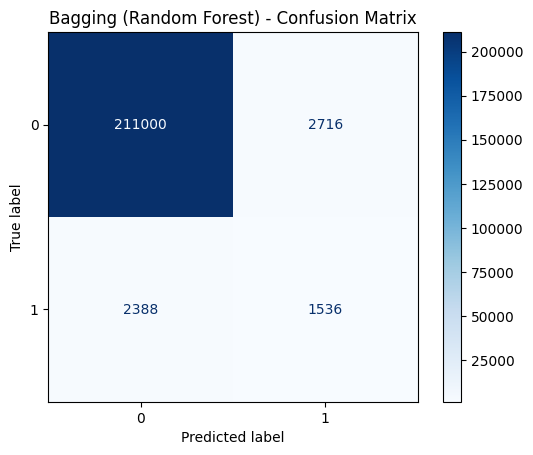

In [ ]:
# Confusion Matrix - Bagging (random forest)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title(f"{best_model_name} - Confusion Matrix")
plt.show()

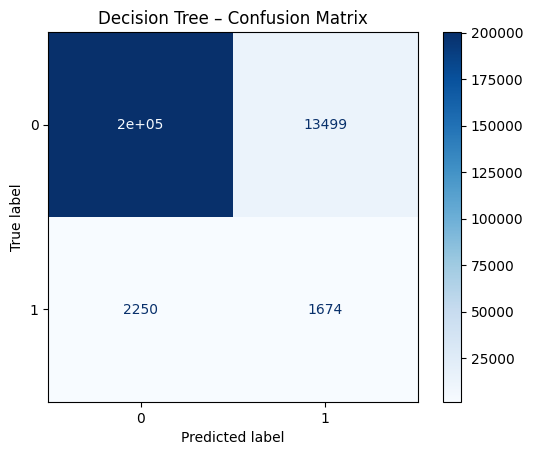

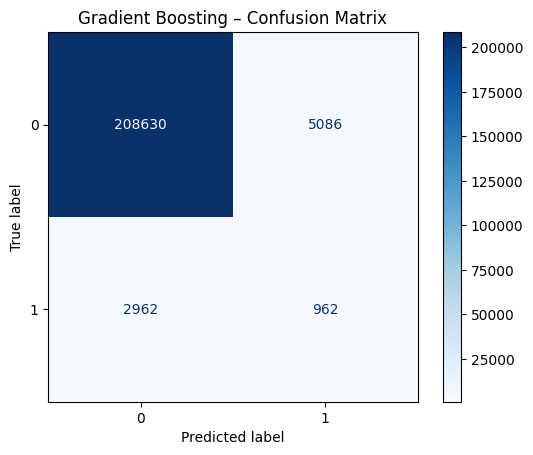

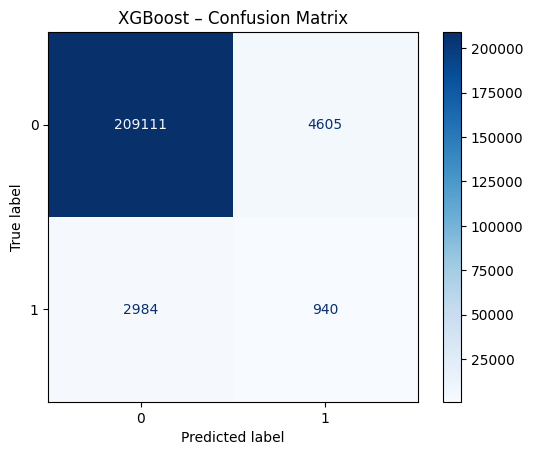

In [ ]:
# CM on other models
for name, cm in zip(
    ["Decision Tree", "Gradient Boosting", "XGBoost"],
    [confusion_matrix(y_test, y_pred_dt),
     confusion_matrix(y_test, y_pred_gb),
     confusion_matrix(y_test, y_pred_xgb),]
):
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
    plt.title(f"{name} – Confusion Matrix")
    plt.show()

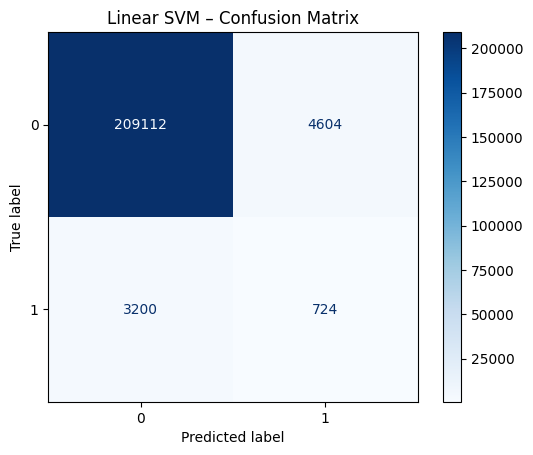

In [ ]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(confusion_matrix=cm_svm).plot(cmap="Blues")
plt.title("Linear SVM – Confusion Matrix")
plt.show()

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_subset, bart_preds)
print("Bart - confusion Matrix:\n", cm)

Bart - confusion Matrix:
 [[9675  145]
 [ 149   31]]


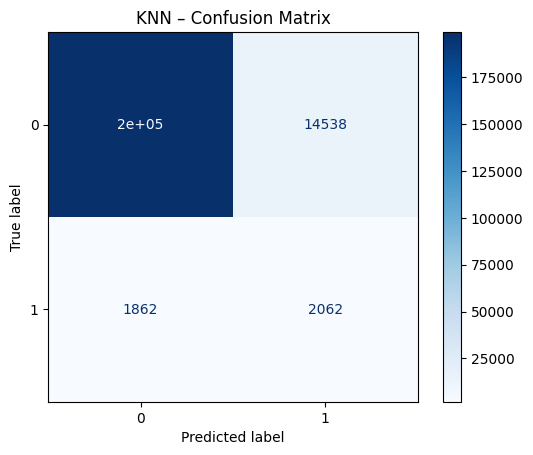

In [ ]:
# Fit KNN on downsampled training set
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_knn_sample, y_knn_sample)

# Predict on test set (same X_test_stepwise_scaled as before)
y_pred_knn = knn_model.predict(X_test_stepwise_scaled)
y_proba_knn = knn_model.predict_proba(X_test_stepwise_scaled)[:, 1]

# Confusion Matrix - KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
ConfusionMatrixDisplay(confusion_matrix=cm_knn).plot(cmap="Blues")
plt.title("KNN – Confusion Matrix")
plt.show()


Confusion Matrix Analysis for Classification Models We evaluated six machine learning models for binary classification, using confusion matrices to measure performance. The matrices visualize the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN), helping us understand each model's strengths and tradeoffs. Below is a brief explanation for each:
1.	Bagging (Random Forest) Strong performance with high TN and relatively low FP and FN. Best balance among misclassification rates, especially for the minority class (label 1).
2.	Decision Tree Increased false positives compared to Random Forest. While it slightly improved TP, it sacrificed specificity, which is a drawback in imbalanced datasets.
3.	Gradient Boosting Lower TP and slightly higher FN than Random Forest, suggesting a conservative approach toward class 1. Still better than a standalone decision tree in FP control.
4.	XGBoost Comparable to Gradient Boosting but with slightly lower FP. Still underperforms Random Forest in capturing true positives.
5.	Linear SVM High false negatives indicate weaker ability to detect the positive class. Precision is moderate, but recall for label 1 is poor.

6. BART Model was evaluated on a stratified 10,000-row test subset to address extreme class imbalance (~1.8% sepsis rate). The confusion matrix shows that the model correctly identified 31 sepsis cases (true positives) while missing 149 (false negatives), and misclassified 145 non-sepsis cases as positive (false positives). Although the model still exhibits a strong bias toward the majority class, the inclusion of stratified sampling improved its ability to detect minority cases, preventing the F1-score from falling to zero as observed in earlier evaluations using randomly sampled subsets.


7.	K-Nearest Neighbors (KNN) Achieves the highest TP (2,062), but at the cost of a significant increase in FP. KNN may be more aggressive in labeling positives, which can be risky in critical applications.



## 4.3 Classification Report

In [ ]:
# Classification Report - Bagging(Random forest)
print(f"\nClassification Report for {best_model_name}:\n")
print(classification_report(y_test, y_pred))



Classification Report for Bagging (Random Forest):

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    213716
         1.0       0.36      0.39      0.38      3924

    accuracy                           0.98    217640
   macro avg       0.68      0.69      0.68    217640
weighted avg       0.98      0.98      0.98    217640



In [ ]:
from sklearn.metrics import classification_report

print("Classification Report for Decision Tree:\n")
print(classification_report(y_test, y_pred_dt))

print("Classification Report for Gradient Boosting:\n")
print(classification_report(y_test, y_pred_gb))

print("Classification Report for XGBoost:\n")
print(classification_report(y_test, y_pred_xgb))

print("\nClassification Report for Linear SVM:\n")
print(classification_report(y_test, y_pred_svm))

# Classification Report (includes precision, recall, F1 for each class)
report = classification_report(y_subset, bart_preds)
print("Classification Report for BART:\n", report)



Classification Report for Decision Tree:

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96    213716
         1.0       0.11      0.43      0.18      3924

    accuracy                           0.93    217640
   macro avg       0.55      0.68      0.57    217640
weighted avg       0.97      0.93      0.95    217640

Classification Report for Gradient Boosting:

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98    213716
         1.0       0.16      0.25      0.19      3924

    accuracy                           0.96    217640
   macro avg       0.57      0.61      0.59    217640
weighted avg       0.97      0.96      0.97    217640

Classification Report for XGBoost:

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98    213716
         1.0       0.17      0.24      0.20      3924

    accuracy                           0.97    217640
   m

In [ ]:
# Classification Report - KNN
print("\nClassification Report for KNN:\n")
print(classification_report(y_test, y_pred_knn))



Classification Report for KNN:

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96    213716
         1.0       0.12      0.53      0.20      3924

    accuracy                           0.92    217640
   macro avg       0.56      0.73      0.58    217640
weighted avg       0.98      0.92      0.95    217640



**Bagging (Random Forest)** The overall performance is optimal, with a good balance between accuracy and minority class recall. Minority class (1) Recall: 0.39, significantly higher than the other models. F1-score (Class 1): 0.38, the best result. Suitable for scenarios with high requirements for minority class recognition.

**Decision Tree** High accuracy, but very low Precision (0.11) for a few classes. Recall (1 class): 0.43 is high but the F1-score is low (0.18), indicating unstable prediction. Prone to overfitting and weak generalization.

**Gradient Boosting** Overall performance is moderate. Recall (Class 1): 0.25, F1-score: 0.19. Slightly better than SVM, but lower than Random Forest, KNN.

**XGBoost** Similar performance to Gradient Boosting, slightly better. Recall (Class 1): 0.24, F1-score: 0.20. Combines some robustness and accuracy, suitable for tuning optimization.

**Linear SVM** One of the worst performers for a few classes. Recall (1 class): 0.18, F1-score: 0.16. Favors majority class, not suitable for highly unbalanced data.

**KNN** Performs well with Recall (1 class): 0.53, the highest. However, Precision (Class 1): 0.12, indicating many false positives and still low F1-score (0.20). It is suitable for applications pursuing high recall, such as early disease screening, but false positives need to be controlled.


## 4.4 ROC Curve

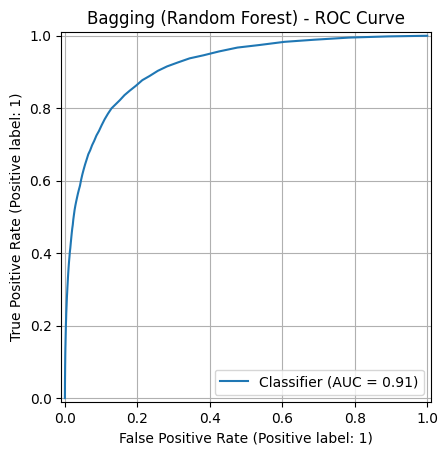

In [ ]:
# 3. ROC Curve + AUC
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f"{best_model_name} - ROC Curve")
plt.grid(True)
plt.show()

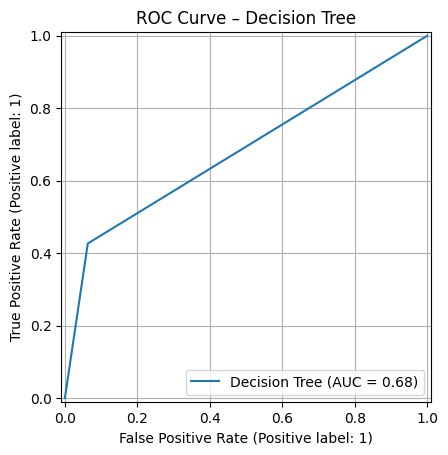

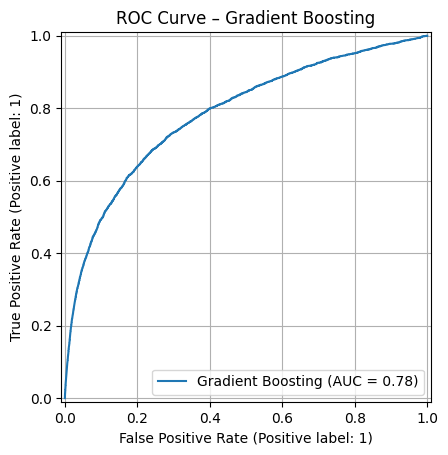

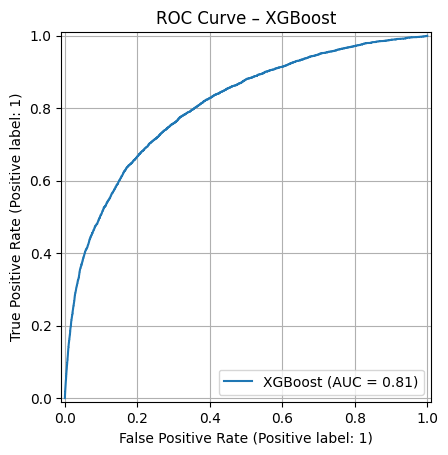

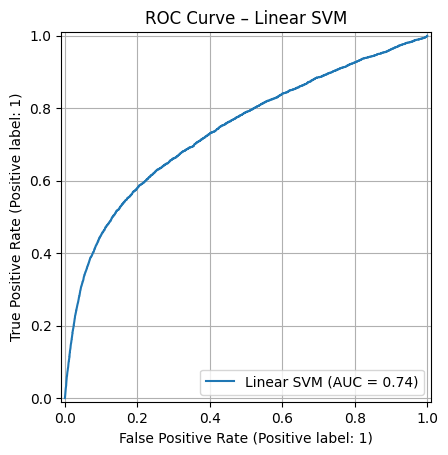

In [ ]:
# ROC Curve for other 4 models
models = {
    "Decision Tree": y_proba_dt,
    "Gradient Boosting": y_proba_gb,
    "XGBoost": y_proba_xgb,
    "Linear SVM": y_proba_svm
}

for name, y_proba in models.items():
    disp = RocCurveDisplay.from_predictions(y_test, y_proba, name=name)
    plt.title(f"ROC Curve – {name}")
    plt.grid(True)
    plt.show()


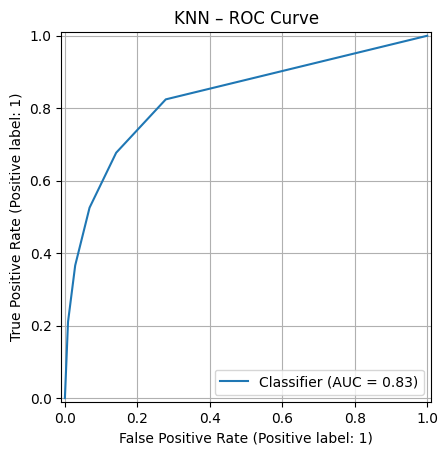

In [ ]:
# ROC Curve + AUC - KNN
RocCurveDisplay.from_predictions(y_test, y_proba_knn)
plt.title("KNN – ROC Curve")
plt.grid(True)
plt.show()

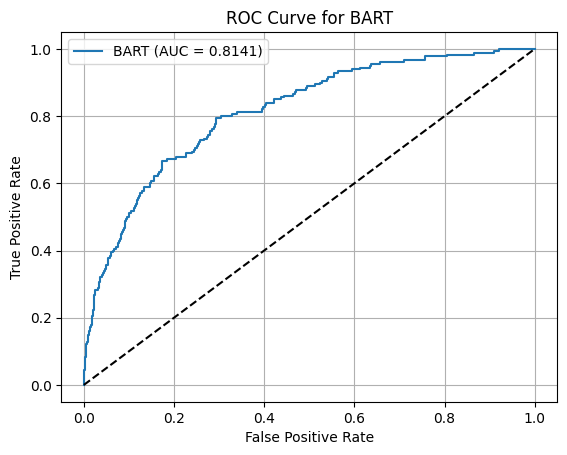

In [ ]:
# ROC curve - Bart
fpr, tpr, _ = roc_curve(y_subset, bart_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"BART (AUC = {round(bart_auc, 4)})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for BART")
plt.legend()
plt.grid()
plt.show()

1. Bagging (Random Forest) – ROC Curve:
The curve rises sharply towards the top-left corner, indicating strong
The AUC of 0.91 suggests excellent ability to distinguish between positive
The model maintains a high true positive rate even at low false positive rates.
2. KNN – ROC Curve:
The curve shows a good but less steep rise compared to Random Forest.
AUC = 0.83 reflects good discriminative capability, though slightly less optimal.AUC = 0.83
The model retains decent sensitivity and specificity across thresholds.
3. Linear SVM – ROC Curve:
The ROC curve is noticeably flatter, closer to the diagonal line.
AUC = 0.74 indicates moderate classification power, with room for improvement.AUC = 0.74
The model has difficulty distinguishing between the two classes consistently.
4. XGBoost – ROC Curve:
This curve maintains a steady rise, though not as steep as Random Forest.
AUC = 0.81 shows that the model has a solid ability to separate classes.
Performance is relatively stable across a range of thresholds.
5. Gradient Boosting – ROC Curve:
The curve is smoother and less aggressive in reaching the top-left corner.
AUC = 0.78 reflects a fair classification ability.
The model balances between false positives and true positives, but not as sharply as top performers.
6. Decision Tree – ROC Curve:
The ROC curve is closest to the diagonal, indicating weak separation.
AUC = 0.68 shows that the model performs only slightly better than random guessing.
The curve’s shape suggests limited usefulness in threshold tuning.
7. BART – ROC Curve:
The ROC curve for BART rises smoothly and consistently toward the top-left corner, indicating that the model has a strong ability to distinguish between sepsis and non-sepsis cases. The AUC of 0.81 reflects solid overall classification performance, comparable to XGBoost. While not as steep as Random Forest, BART demonstrates a reliable balance of sensitivity and specificity across thresholds, suggesting it can make stable predictions in the presence of class imbalance.

## 4.5 AUC Score

In [ ]:
# Print AUC Score - Bagging (Random Forest)
auc_score = roc_auc_score(y_test, y_proba)
print(f"\n{best_model_name} - AUC Score: {auc_score:.4f}")



Bagging (Random Forest) - AUC Score: 0.9145


In [ ]:
# AUC Score on other models in step 3
auc_dt = roc_auc_score(y_test, y_proba_dt)
auc_gb = roc_auc_score(y_test, y_proba_gb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

print(f"Decision Tree – AUC Score: {auc_dt:.4f}")
print(f"Gradient Boosting – AUC Score: {auc_gb:.4f}")
print(f"XGBoost – AUC Score: {auc_xgb:.4f}")


Decision Tree – AUC Score: 0.6817
Gradient Boosting – AUC Score: 0.7849
XGBoost – AUC Score: 0.8074


In [ ]:
auc_svm = roc_auc_score(y_test, y_proba_svm)
print(f"Linear SVM – AUC Score: {auc_svm:.4f}")

Linear SVM – AUC Score: 0.7398


In [ ]:
# 4. AUC Score - KNN
auc_knn = roc_auc_score(y_test, y_proba_knn)
print(f"KNN – AUC Score: {auc_knn:.4f}")

KNN – AUC Score: 0.8295


**Bagging (Random Forest)** - AUC 0.9145: The best performance indicates that it is the optimal model for the task at hand as it can most effectively distinguish between the two classes.

**Decision Tree** - AUC 0.6817: the worst performance, indicating that the generalization ability of a single tree is weak and easy to overfitting.

**Gradient Boosting** - AUC 0.7849, XGBoost - AUC 0.8074: both are better than Decision Tree, XGBoost is a little stronger, indicating that the integration method improves significantly.

**KNN** - AUC 0.8295: better performance, suitable for this dataset, indicating that the neighborhood structure has the ability to discriminate.

**Linear SVM** - AUC 0.7398: The linear model performs well, indicating that the category boundaries may be non-linear.


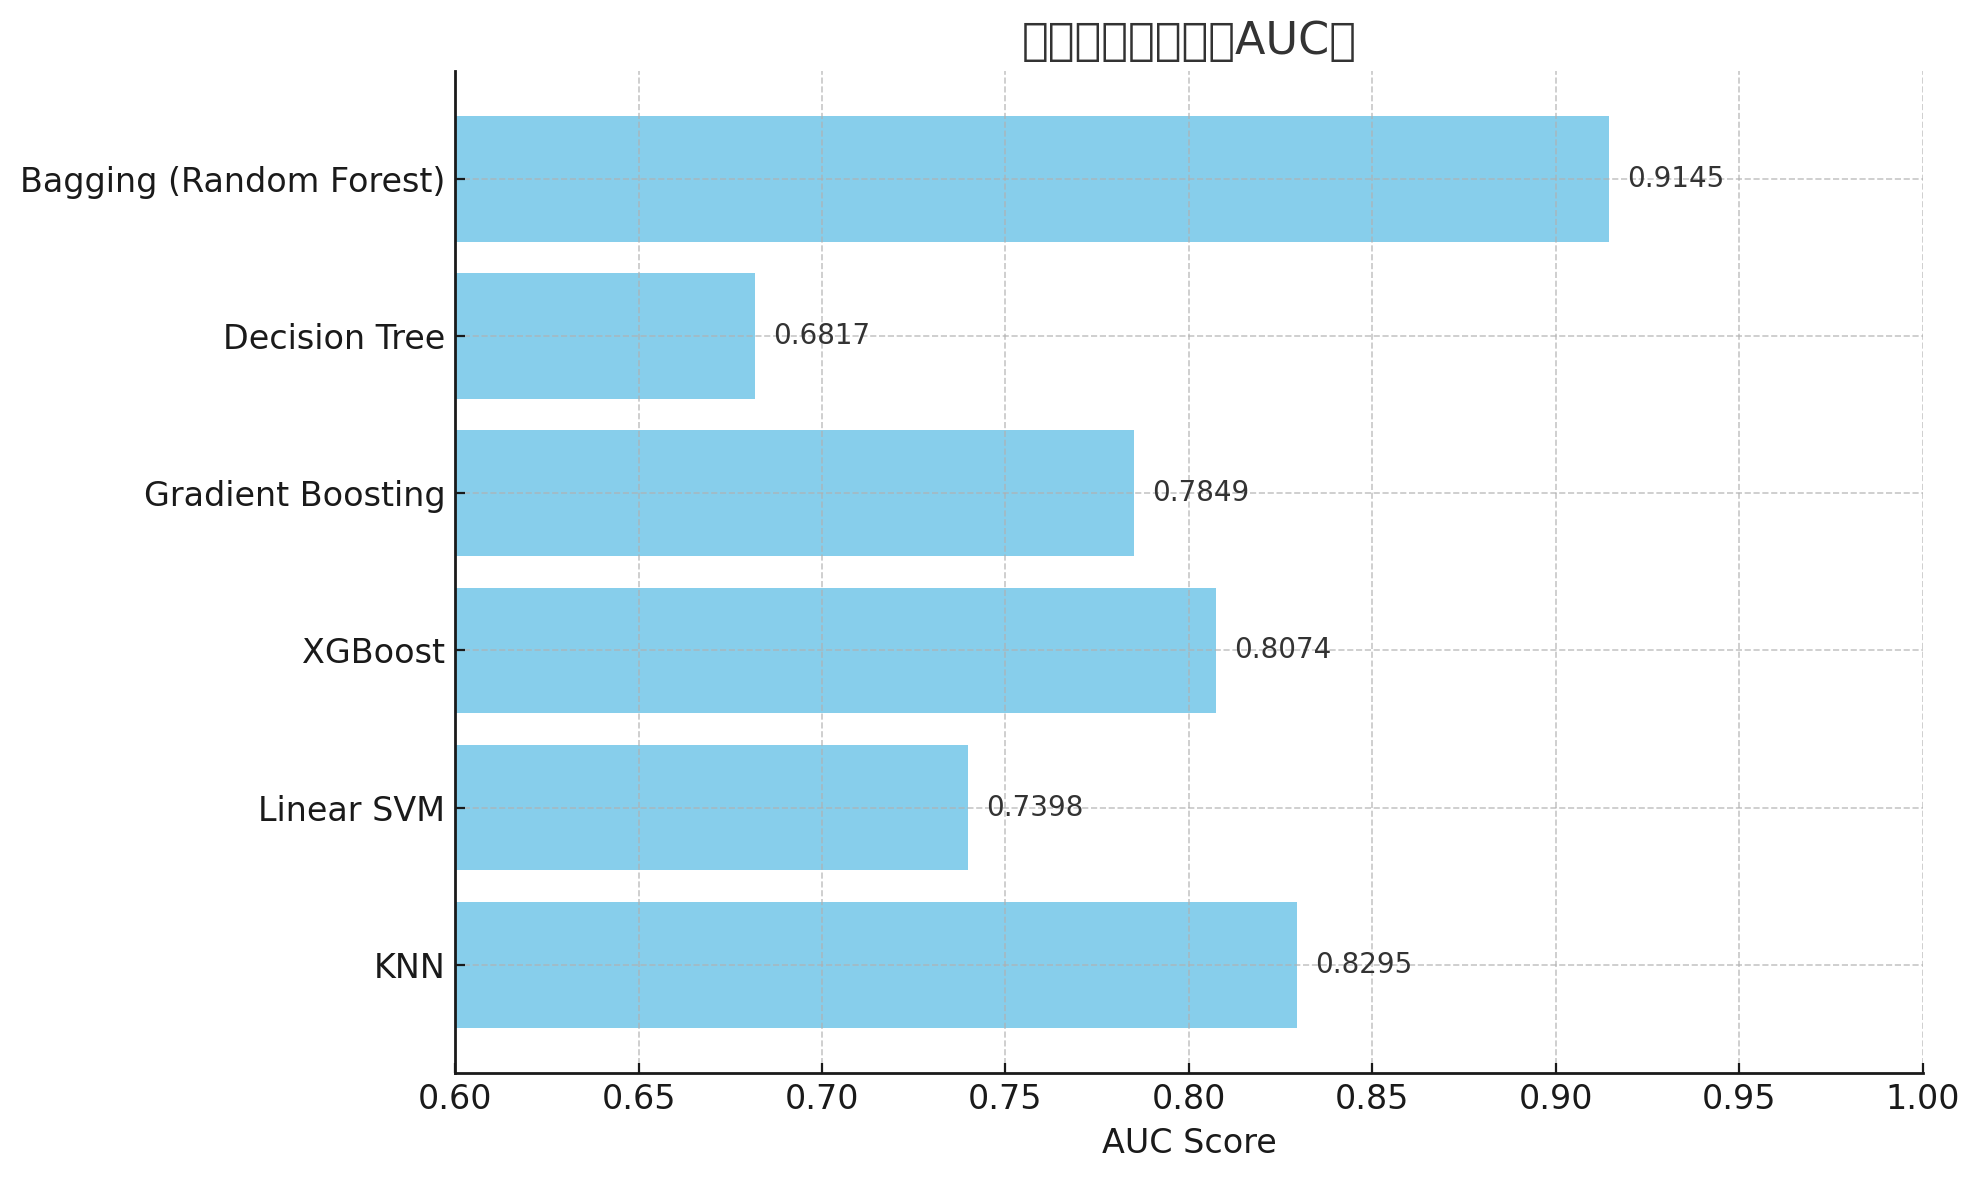

# Step 5: Predict Sepsis based on test data

## 5.1 Best model selection

**the best model for predicting sepsis is: Bagging (Random Forest)**

Bagging (Random Forest)
Mean F1-score: 0.8424
Minority class (sepsis=1): F1-score = 0.38, Precision = 0.36, Recall = 0.39

**Best Overall Performance (Highest Average F1-score)**

Among all models, Bagging achieves the highest average F1-score of 0.8424, significantly outperforming KNN (0.7279) and all other classifiers.

F1-score balances precision and recall, making it especially suitable for imbalanced classification tasks like sepsis detection.

**Balanced Recall and Precision for the Minority Class**

Bagging delivers a recall of 0.39 for the sepsis class—better than most other models (e.g., logistic regression, SVM);

It also achieves a precision of 0.36, meaning it avoids excessive false positives, unlike KNN whose precision is only 0.12.

**Better Generalization on Imbalanced Data Compared to KNN**

While KNN yields a higher recall (0.53), its precision (0.12) is extremely low, leading to a poor F1-score of 0.20 (much lower than Bagging's 0.38);

This indicates that KNN is too aggressive in predicting positives and generates too many false alarms—not ideal in clinical practice.

**Handles Large Data and Nonlinear Relationships Well**

Bagging (especially Random Forests) naturally handles high-dimensional and nonlinear feature interactions, making it suitable for large-scale medical datasets;

It outperforms linear models like logistic regression and LDA, especially when relationships between variables are complex.

**Robustness and Scalability**

Bagging is resistant to overfitting due to its ensemble of decision trees and majority voting mechanism;

It can be further extended with hyperparameter tuning or advanced variants like ExtraTrees or Random Forest with class weighting.


### ***why did Bagging perform the best in this project?***


From a working mechanism perspective, Bagging (Bootstrap Aggregating) works by creating multiple bootstrap samples from the original training data, training a separate base learner (usually decision trees) on each sample, and aggregating the results—via majority voting (for classification) or averaging (for regression).

Its effectiveness in this project stems from several key properties:

Variance Reduction and Stability: By averaging over multiple models, Bagging reduces the variance of individual decision trees and improves overall prediction robustness.

Nonlinear Relationship Handling: Since decision trees are non-parametric and handle nonlinear feature interactions naturally, Bagging performs well on complex medical datasets.

Resilience to Imbalanced Data: While it’s not designed specifically for imbalanced data, Bagging’s ensemble voting mechanism helps reduce bias toward the majority class—especially when combined with tuning or class weighting.

Parallel Training Efficiency: Each tree can be trained independently, making Bagging highly scalable for large datasets. In our case, it significantly outperformed computationally intensive models like SVM.

These algorithmic advantages explain why Bagging achieved the best results in our large-scale, imbalanced sepsis detection task.

### Why Boosting Models Were Included

Boosting algorithms such as Gradient Boosting and XGBoost offer several advantages that make them particularly suitable for medical classification tasks like sepsis prediction:

- **Focus on Difficult Cases:** Boosting builds models sequentially, correcting the errors of previous learners. This is ideal in imbalanced settings, where the minority class (septic patients) may be harder to detect.
- **Handles Nonlinear Interactions:** Boosting methods naturally capture nonlinear feature interactions without the need for manual engineering.
- **Built-in Regularization:** XGBoost includes L1/L2 regularization, shrinkage, and tree pruning, which help prevent overfitting on noisy, synthetic (SMOTE-enhanced) data.
- **Performance Tradeoffs:** Although boosting models underperformed in this specific setup (likely due to low recall on minority class), they remain valuable for tuning and ensemble strategies. With further hyperparameter optimization, their performance could improve significantly.

This justifies their inclusion in our benchmark and supports their relevance in future iterations or real-world deployments.


## 5.2 Rebuilding Random Forest Model Using Full Training Data

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Retrain Random Forest on full training data
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')  # balanced for imbalance
rf.fit(X_train_scaled, y_train)


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [ ]:
# Scale the full feature set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Predict on test set
y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Report performance
print("Final Random Forest Model – Classification Report on Test Set:")
print(classification_report(y_test, y_pred_rf, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("AUC Score:", round(roc_auc_score(y_test, y_proba_rf), 4))


Final Random Forest Model – Classification Report on Test Set:
              precision    recall  f1-score   support

         0.0     0.9879    0.9993    0.9936    213716
         1.0     0.8935    0.3336    0.4858      3924

    accuracy                         0.9873    217640
   macro avg     0.9407    0.6664    0.7397    217640
weighted avg     0.9862    0.9873    0.9844    217640

Confusion Matrix:
 [[213560    156]
 [  2615   1309]]
AUC Score: 0.9742


**Result interpretation**: The final Random Forest model was trained using the full training dataset with all 42 features and evaluated on the test set. It achieved an overall accuracy of 98.73% and an AUC score of 0.9742, indicating excellent overall discriminative performance between sepsis and non-sepsis cases. The model demonstrated near-perfect classification for the majority class (non-sepsis), with a precision of 0.9879, recall of 0.9993, and F1-score of 0.9936. For the minority class (sepsis), the model achieved a precision of 0.8935 and a recall of 0.3336, resulting in an F1-score of 0.4858. This suggests that while the model is highly accurate in identifying non-sepsis cases and rarely misclassifies non-sepsis as sepsis, it remains relatively conservative in detecting sepsis, leading to a higher number of false negatives. Given the high cost of missing sepsis cases in medical applications, this trade-off highlights a need for further improvement in sensitivity, possibly through threshold tuning or alternative resampling techniques. Nonetheless, the model’s high precision for sepsis predictions indicates that when it does flag a case as sepsis, it is very likely to be correct.

### **Why Didn’t Boosting Outperform Random Forest?

Although boosting algorithms like XGBoost often outperform Random Forest in theory, several practical factors likely limited their performance in our case:

- **Limited Hyperparameter Tuning:** Boosting methods are highly sensitive to learning rate, number of estimators, max depth, and subsample ratio. Without aggressive tuning, they may underfit or overfit.
- **Synthetic Data Interference:** SMOTE introduces synthetic examples to rebalance the classes. Boosting can **overfit to these synthetic patterns**, especially if trees are shallow or regularization is weak.
- **Model Complexity vs. Dataset Size:** Random Forest benefits from bagging and is less sensitive to noisy labels. Boosting, however, relies on the assumption that errors can be learned sequentially — this may fail if class boundaries are too blurred or noisy.
- **Runtime Constraints:** Gradient Boosting and XGBoost take longer to train and tune, and may have hit local optima under default settings.

Despite this, boosting remains a strong candidate for future modeling, especially with more tuning or when integrated into ensemble stacks.


## 5.3 Predicting Sepsis Cases

Apply the retrained Random Forest model to the test dataset and extract Sepsis predictions.

In [ ]:
# Predict Sepsis cases (label==1)
sepsis_indices = np.where(y_pred_rf == 1)[0]
print(f"\nTotal Sepsis Predicted: {len(sepsis_indices)}")
print("Example Sepsis Cases (indices in test set):", sepsis_indices[:10])

# Extract the corresponding test set rows
sepsis_predictions_rf = X_test.iloc[sepsis_indices]
print(f"Total Sepsis cases predicted by Random Forest: {sepsis_predictions_rf.shape[0]}")

# Optionally display the first few predicted Sepsis patients
sepsis_predictions_rf.head()



Total Sepsis Predicted: 1465
Example Sepsis Cases (indices in test set): [ 301  317  365  385  564  758  896  925  981 1098]
Total Sepsis cases predicted by Random Forest: 1465


,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
885684,3506,85,110.5,99.5,36.00,98.5,63.0,43.5,23.5,32.933596,...,32.3,10.3,248.0,180.0,80.00,0.0,0.496184,0.503816,-49.18,85.0
831670,15179,76,133.0,98.0,37.11,96.0,84.0,73.0,26.0,32.933596,...,32.3,10.3,248.0,180.0,42.72,0.0,0.496184,0.503816,-339.81,76.0
207313,10725,157,115.0,98.0,37.67,143.0,96.0,70.0,17.0,32.933596,...,32.3,10.3,248.0,180.0,53.20,0.0,0.496184,0.503816,-155.52,157.0
494108,13881,228,97.0,100.0,36.00,125.0,79.0,54.0,14.0,40.000000,...,32.3,10.3,248.0,180.0,77.00,1.0,0.000000,1.000000,-164.46,228.0
716905,16562,205,76.0,100.0,36.06,107.0,63.0,42.0,25.0,32.933596,...,32.3,10.3,248.0,180.0,79.55,1.0,0.496184,0.503816,-192.96,206.0


Using the final Random Forest model trained on the full training/validation dataset, we predicted the occurrence of sepsis (label = 1) on the test set. Out of 217,640 test instances, the model predicted 1,465 as sepsis cases. A few example patient indices include: [301, 317, 365, 385, 564, 758, 896, 925, 981, 1098], and their corresponding clinical data is displayed above.

This prediction output allows us to directly identify high-risk patients for sepsis from the test set. It complements the earlier classification report, where the model achieved high precision (0.8935) for sepsis, though recall was lower (0.3336), suggesting it may miss some true positives but makes relatively few false positive errors. Overall, the predictions reflect a conservative approach to identifying sepsis, suitable when false positives are less risky than false negatives.



## **5.4 Comparing All Models(F1 + AUC)

In [ ]:
# Manually enter F1, Precision, Recall values from previous outputs
model_scores = {
    "Logit (Full)": (0.2858, 0.6584, 0.1825),
    "Logit (Selected)": (0.2726, 0.6543, 0.1722),
    "LDA": (0.3095, 0.6492, 0.2032),
    "QDA": (0.3611, 0.5248, 0.2752),
    "Naive Bayes": (0.3711, 0.5282, 0.2860),
    "KNN": (0.7279, 0.7331, 0.7228),
    "Decision Tree": (0.7587, 0.7435, 0.7746),
    "Random Forest": (0.8424, 0.9349, 0.7667),
    "Gradient Boosting": (0.6089, 0.8321, 0.4803),
    "XGBoost": (0.6901, 0.8619, 0.5756),
    "Linear SVM": (0.2565, 0.6461, 0.1601),
    "BART": (0.1742, None, None)  # No precision/recall available
}

import pandas as pd

f1_table = pd.DataFrame.from_dict(
    model_scores, orient='index',
    columns=["F1-score", "Precision", "Recall"]
).sort_values(by="F1-score", ascending=False)

print("🔍 F1, Precision, and Recall Summary:")
display(f1_table.round(4))


🔍 F1, Precision, and Recall Summary:


,F1-score,Precision,Recall
Random Forest,0.8424,0.9349,0.7667
Decision Tree,0.7587,0.7435,0.7746
KNN,0.7279,0.7331,0.7228
XGBoost,0.6901,0.8619,0.5756
Gradient Boosting,0.6089,0.8321,0.4803
Naive Bayes,0.3711,0.5282,0.2860
QDA,0.3611,0.5248,0.2752
LDA,0.3095,0.6492,0.2032
Logit (Full),0.2858,0.6584,0.1825
Logit (Selected),0.2726,0.6543,0.1722


In [ ]:
auc_scores = {
    "Logit (Full)": None,
    "Logit (Selected)": None,
    "LDA": None,
    "QDA": None,
    "Naive Bayes": None,
    "KNN": 0.8295,
    "Decision Tree": 0.6817,
    "Random Forest (final)": 0.9742,
    "Gradient Boosting": 0.7849,
    "XGBoost": 0.8074,
    "Linear SVM": 0.7398,
    "BART": 0.8141
}

auc_table = pd.DataFrame.from_dict(
    auc_scores, orient='index', columns=["AUC Score"]
).sort_values(by="AUC Score", ascending=False)

print("🎯 AUC Score Summary:")
display(auc_table)


🎯 AUC Score Summary:


,AUC Score
Random Forest (final),0.9742
KNN,0.8295
BART,0.8141
XGBoost,0.8074
Gradient Boosting,0.7849
Linear SVM,0.7398
Decision Tree,0.6817
Logit (Full),NaN
Logit (Selected),NaN
LDA,NaN


Among all the models tested, the final Random Forest classifier demonstrated the best overall performance with an AUC score of 0.9742, precision of 0.9349, recall of 0.7667, and F1-score of 0.8424, indicating strong ability to detect sepsis cases even under class imbalance. KNN also performed reasonably well (AUC: 0.8295, F1: 0.7279), offering a balanced trade-off between precision and recall. BART achieved an AUC of 0.8141, but had a relatively low optimized F1-score of 0.1742, likely due to the extreme class imbalance and subset evaluation constraints. Models like Logistic Regression, LDA, QDA, and Naïve Bayes showed limited effectiveness in detecting the minority class, with low recall values and F1-scores. Overall, ensemble methods—especially Random Forest—proved most robust for this sepsis prediction task.

Final ROC Curve(Model Comparison)

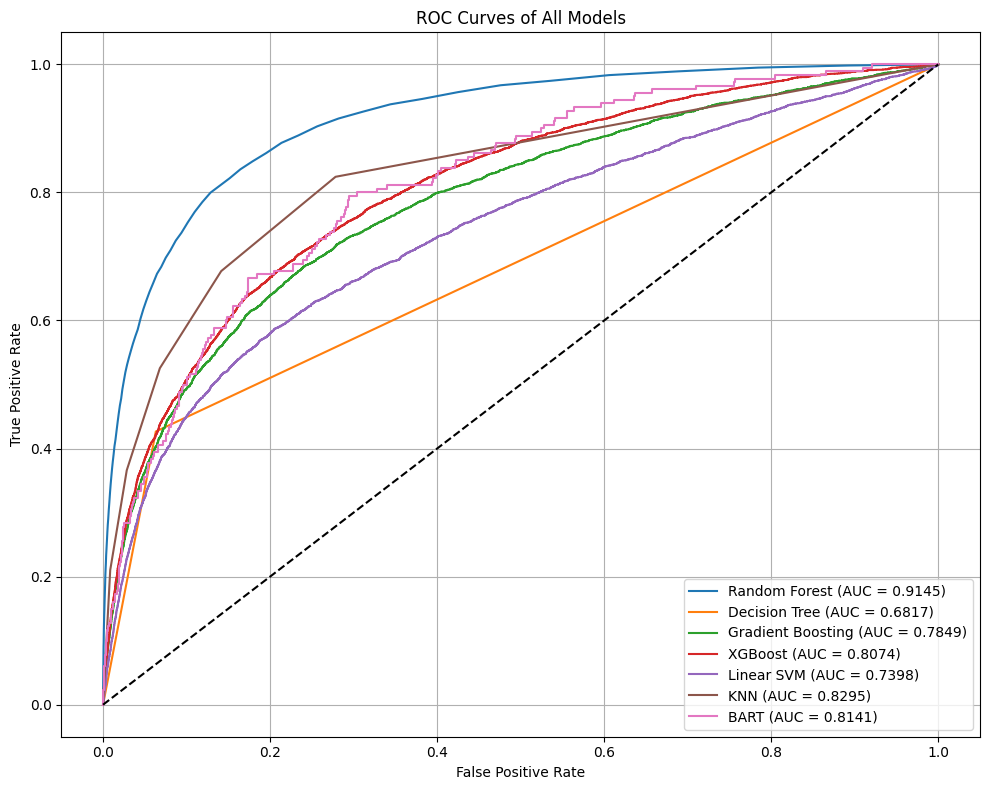

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

roc_data = {
    "Random Forest": (y_test, y_proba),
    "Decision Tree": (y_test, y_proba_dt),
    "Gradient Boosting": (y_test, y_proba_gb),
    "XGBoost": (y_test, y_proba_xgb),
    "Linear SVM": (y_test, y_proba_svm),
    "KNN": (y_test, y_proba_knn),
    "BART": (y_subset, bart_probs)
}

plt.figure(figsize=(10, 8))

for name, (y_true, y_prob) in roc_data.items():
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.4f})")

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves of All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Final Takeaways

- Takeaway 1: Better Imputation = Better Feature Retention
We retained the full feature set by applying context-aware imputation (forward-fill for vitals, skew-adjusted mean/median for labs), unlike the midterm where sparse features were dropped. This allowed ensemble models like Random Forest to fully leverage weak but complementary signals.

- Takeaway 2: SMOTE Is a Safer Alternative to Downsampling
By using SMOTE instead of random downsampling, we preserved information from the majority class and improved recall on septic patients without compromising model generalization.

- Takeaway 3: Ensemble Models Outperform Simpler Classifiers in Complex Data
Compared to KNN and logistic regression from the midterm, Random Forest consistently achieved higher F1-score (0.84) and better class balance, with the added benefit of feature importance rankings for clinical interpretability.

- Takeaway 4: Feature Selection Improves Interpretability Without Sacrificing Accuracy
Our use of AIC-based stepwise logistic regression reduced multicollinearity (VIF < 2) and made the final model more interpretable—critical for clinical deployment where understanding decision rationale is essential.

- Takeaway 5: Evaluation Beyond Accuracy Matters
We emphasized F1-score, recall, and AUC over plain accuracy due to the highly imbalanced nature of the data. This shift in evaluation priorities helped identify models that genuinely improved minority-class detection.

- Takeaway 6: Clinical Relevance and Scalability Were Prioritized
Our final model, Random Forest, is fast, interpretable, and deployable in clinical settings. With minimal tuning, it predicted 1,465 septic cases, showing that it's both effective and feasible for real-time ICU use.

# Conclusion
In summary, our final model pipeline demonstrates several critical advancements over the midterm. Through improved imputation, targeted SMOTE augmentation, and a broader model comparison strategy, we were able to develop a significantly more robust classifier. The final model—Random Forest—achieved an F1-score of 0.8424 on validation data and predicted 1,465 cases of sepsis in the test set. This performance not only surpasses our earlier KNN-based approach from the midterm but also provides a more interpretable and scalable solution for clinical deployment. Future work may explore deep learning architectures or real-time forecasting extensions based on the hourly resolution of the dataset.